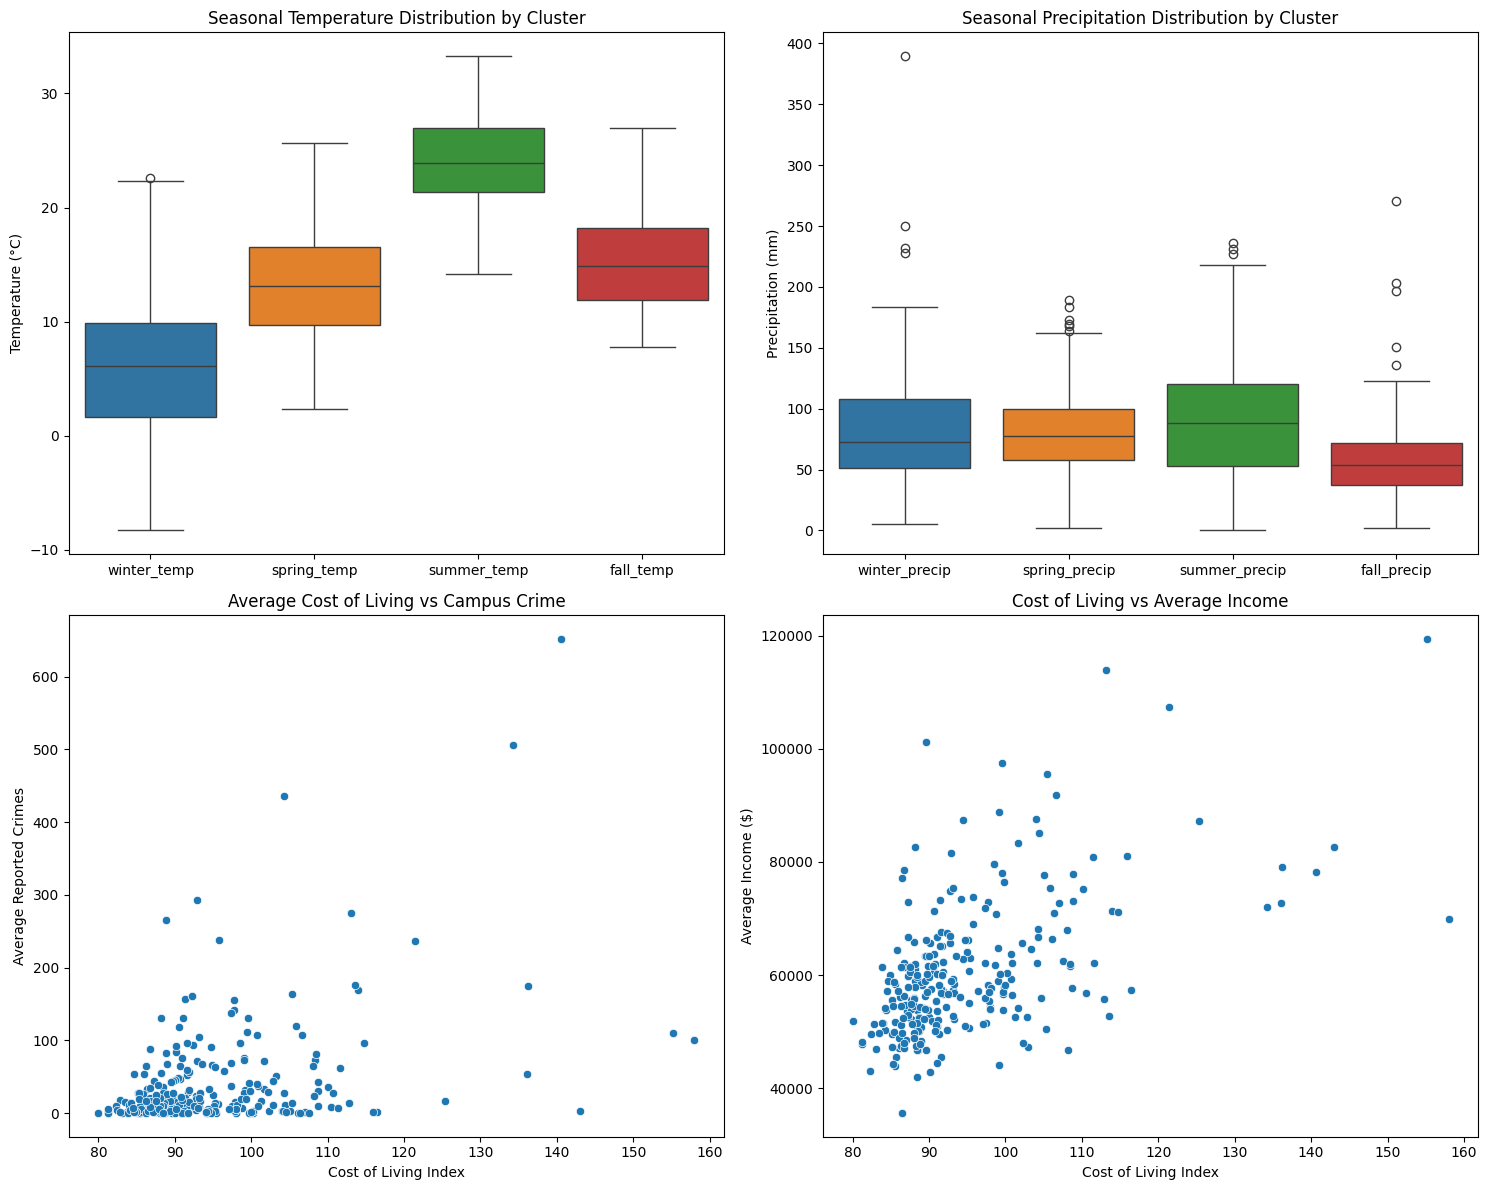

Streaming output truncated to the last 5000 lines.

CLIMATE PROFILE
Seasonal Temperatures (°C):
  Winter:   11.9°C
  Spring:   19.6°C
  Summer:   31.0°C
  Fall  :   21.2°C

Seasonal Precipitation (mm):
  Winter:   49.9mm
  Spring:   75.3mm
  Summer:    3.7mm
  Fall  :   70.3mm
  Annual:   49.8mm


CLUSTER 139
----------------------------------------
Universities: 16
Major Cities: Albuquerque

ECONOMIC PROFILE
Cost of Living Index: 92.9
  Range: 92.9 - 92.9
Average Income: $58,895
  Range: $58,895 - $58,895

CAMPUS SAFETY PROFILE
Average Reported Crimes: 293.0
Total Reported Crimes: 4688
Campuses with Low Crime (<5 reports): 0
Campuses with High Crime (>10 reports): 16

CLIMATE PROFILE
Seasonal Temperatures (°C):
  Winter:    3.0°C
  Spring:   13.0°C
  Summer:   25.8°C
  Fall  :   14.8°C

Seasonal Precipitation (mm):
  Winter:   15.1mm
  Spring:    9.5mm
  Summer:   11.7mm
  Fall  :   16.4mm
  Annual:   13.2mm


CLUSTER 140
----------------------------------------
Universities: 8
Major 

In [2]:
import folium
import pandas as pd
import numpy as np
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
clusters_df = pd.read_csv('latitude_longitude_with_clusters.csv')
city_data = pd.read_csv('final_merged_data_with_weather.csv')

# Function to find nearest city data
def find_nearest_city(lat, lon, city_df):
    distances = ((city_df['latitude'] - lat)**2 + (city_df['longitude'] - lon)**2)**0.5
    return city_df.iloc[distances.idxmin()]

# Calculate seasonal metrics
for season in ['winter', 'spring', 'summer', 'fall']:
    if season == 'winter':
        months = [12, 1, 2]
    elif season == 'spring':
        months = [3, 4, 5]
    elif season == 'summer':
        months = [6, 7, 8]
    else:  # fall
        months = [9, 10, 11]

    # Temperature
    temp_cols = [f'temp_month_{m}' for m in months]
    city_data[f'{season}_temp'] = city_data[temp_cols].mean(axis=1)

    # Precipitation
    precip_cols = [f'precip_month_{m}' for m in months]
    city_data[f'{season}_precip'] = city_data[precip_cols].mean(axis=1)

# Create map
m = folium.Map(location=[37.5, -98.0], zoom_start=5)
marker_cluster = MarkerCluster().add_to(m)

# Add markers with data
for _, uni in clusters_df.iterrows():
    city_data_point = find_nearest_city(uni['LATITUDE'], uni['LONGITUDE'], city_data)

    adjusted_cost = (city_data_point['Cost of Living Index'] / 100) * 77280
    cost_of_food = adjusted_cost*.161
    cost_of_housing = adjusted_cost*.232
    cost_of_utils = adjusted_cost*.101
    cost_of_transportation = adjusted_cost*.186
    cost_of_healthcare = adjusted_cost*.096

    popup_content = f"""
    <div style='width: 300px'>
        <h4>Cluster {uni['Clusters']}</h4>
        <b>Location:</b> {city_data_point['City']}, {city_data_point['State']}<br>
        <b>Economic Profile:</b><br>
        Cost of Living Index: {city_data_point['Cost of Living Index']:.1f}<br>
        Adjusted Cost of Living per Year(77,280 base): ${adjusted_cost:,.2f}<br>
        Average Food Expenses: ${cost_of_food:,.2f}<br>
        Average Housing Expenses: ${cost_of_housing:,.2f}<br>
        Average Utilities Expenses: ${cost_of_utils:,.2f}<br>
        Average Transportation Expenses: ${cost_of_transportation:,.2f}<br>
        Average Healthcare Expenses: ${cost_of_healthcare:,.2f}<br>
        Average Income: ${city_data_point['Average Income']:,.0f}<br>
        <b>Campus Safety:</b><br>
        Reported Crimes: {city_data_point['total_crime']}<br>
        <b>Climate:</b><br>
        <i>Temperature (°C):</i><br>
        Winter: {city_data_point['winter_temp']:.1f}<br>
        Spring: {city_data_point['spring_temp']:.1f}<br>
        Summer: {city_data_point['summer_temp']:.1f}<br>
        Fall: {city_data_point['fall_temp']:.1f}<br>
        <i>Precipitation (mm):</i><br>
        Winter: {city_data_point['winter_precip']:.1f}<br>
        Spring: {city_data_point['spring_precip']:.1f}<br>
        Summer: {city_data_point['summer_precip']:.1f}<br>
        Fall: {city_data_point['fall_precip']:.1f}
    </div>
    """

    # Color based on crime reports
    if city_data_point['total_crime'] < 5:
        color = 'green'  # safe campus
    elif city_data_point['total_crime'] > 10:
        color = 'red'    # high crime
    else:
        color = 'orange' # moderate

    folium.Marker(
        location=[uni['LATITUDE'], uni['LONGITUDE']],
        popup=popup_content,
        icon=folium.Icon(color=color)
    ).add_to(marker_cluster)

# Create visualization plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Calculate cluster statistics for plotting
cluster_stats = {}
for cluster_id in clusters_df['Clusters'].unique():
    cluster_unis = clusters_df[clusters_df['Clusters'] == cluster_id]
    cluster_data = pd.DataFrame([find_nearest_city(row['LATITUDE'], row['LONGITUDE'], city_data)
                                for _, row in cluster_unis.iterrows()])

    cluster_stats[cluster_id] = {
        'avg_cost': cluster_data['Cost of Living Index'].mean(),
        'avg_income': cluster_data['Average Income'].mean(),
        'avg_crime': cluster_data['total_crime'].mean(),
        'winter_temp': cluster_data['winter_temp'].mean(),
        'spring_temp': cluster_data['spring_temp'].mean(),
        'summer_temp': cluster_data['summer_temp'].mean(),
        'fall_temp': cluster_data['fall_temp'].mean(),
        'winter_precip': cluster_data['winter_precip'].mean(),
        'spring_precip': cluster_data['spring_precip'].mean(),
        'summer_precip': cluster_data['summer_precip'].mean(),
        'fall_precip': cluster_data['fall_precip'].mean()
    }

cluster_df = pd.DataFrame(cluster_stats).T


# 1. Seasonal Temperature Distribution
temp_data = cluster_df[['winter_temp', 'spring_temp', 'summer_temp', 'fall_temp']]
sns.boxplot(data=temp_data, ax=ax1)
ax1.set_title('Seasonal Temperature Distribution by Cluster')
ax1.set_ylabel('Temperature (°C)')

# 2. Seasonal Precipitation Distribution
precip_data = cluster_df[['winter_precip', 'spring_precip', 'summer_precip', 'fall_precip']]
sns.boxplot(data=precip_data, ax=ax2)
ax2.set_title('Seasonal Precipitation Distribution by Cluster')
ax2.set_ylabel('Precipitation (mm)')

# 3. Cost vs Safety Scatter
sns.scatterplot(data=cluster_df, x='avg_cost', y='avg_crime', ax=ax3)
ax3.set_title('Average Cost of Living vs Campus Crime')
ax3.set_xlabel('Cost of Living Index')
ax3.set_ylabel('Average Reported Crimes')

# 4. Cost vs Income Distribution
sns.scatterplot(data=cluster_df, x='avg_cost', y='avg_income', ax=ax4)
ax4.set_title('Cost of Living vs Average Income')
ax4.set_xlabel('Cost of Living Index')
ax4.set_ylabel('Average Income ($)')

plt.tight_layout()
plt.show()

m.save('cluster_visualization.html')

# After calculating cluster_stats, but before the print statements, add this code to create the profiles dictionary:

profiles = {}
for cluster_id in clusters_df['Clusters'].unique():
    cluster_unis = clusters_df[clusters_df['Clusters'] == cluster_id]
    cluster_data = pd.DataFrame([find_nearest_city(row['LATITUDE'], row['LONGITUDE'], city_data)
                                for _, row in cluster_unis.iterrows()])

    profiles[cluster_id] = {
        'size': {
            'num_universities': len(cluster_unis),
            'major_cities': ', '.join(cluster_data['City'].unique()[:3])  # List up to 3 major cities
        },
        'economics': {
            'avg_cost_index': cluster_data['Cost of Living Index'].mean(),
            'cost_range': (cluster_data['Cost of Living Index'].min(),
                          cluster_data['Cost of Living Index'].max()),
            'avg_income': cluster_data['Average Income'].mean(),
            'income_range': (cluster_data['Average Income'].min(),
                           cluster_data['Average Income'].max())
        },
        'safety': {
            'avg_reported_crimes': cluster_data['total_crime'].mean(),
            'total_reported_crimes': cluster_data['total_crime'].sum(),
            'num_safe_campuses': len(cluster_data[cluster_data['total_crime'] < 5]),
            'num_high_crime_campuses': len(cluster_data[cluster_data['total_crime'] > 10])
        },
        'climate': {
            'temperature': {
                'winter': cluster_data['winter_temp'].mean(),
                'spring': cluster_data['spring_temp'].mean(),
                'summer': cluster_data['summer_temp'].mean(),
                'fall': cluster_data['fall_temp'].mean()
            },
            'precipitation': {
                'winter': cluster_data['winter_precip'].mean(),
                'spring': cluster_data['spring_precip'].mean(),
                'summer': cluster_data['summer_precip'].mean(),
                'fall': cluster_data['fall_precip'].mean(),
                'annual': cluster_data[['winter_precip', 'spring_precip',
                                      'summer_precip', 'fall_precip']].mean(axis=1).mean()
            }
        }
    }

# Then the print statements will work as intended
print("\nUNIVERSITY CLUSTER PROFILES")
print("=" * 80, "\n")

for cluster_id, profile in profiles.items():
    print(f"CLUSTER {cluster_id}")
    print("-" * 40)

    # Size and Location
    print(f"Universities: {profile['size']['num_universities']}")
    print(f"Major Cities: {profile['size']['major_cities']}")
    print()

    # Economic Profile
    print("ECONOMIC PROFILE")
    print(f"Cost of Living Index: {profile['economics']['avg_cost_index']:.1f}")
    print(f"  Range: {profile['economics']['cost_range'][0]:.1f} - {profile['economics']['cost_range'][1]:.1f}")
    print(f"Average Income: ${profile['economics']['avg_income']:,.0f}")
    print(f"  Range: ${profile['economics']['income_range'][0]:,.0f} - ${profile['economics']['income_range'][1]:,.0f}")
    print()

    # Safety Profile
    print("CAMPUS SAFETY PROFILE")
    print(f"Average Reported Crimes: {profile['safety']['avg_reported_crimes']:.1f}")
    print(f"Total Reported Crimes: {profile['safety']['total_reported_crimes']}")
    print(f"Campuses with Low Crime (<5 reports): {profile['safety']['num_safe_campuses']}")
    print(f"Campuses with High Crime (>10 reports): {profile['safety']['num_high_crime_campuses']}")
    print()

    # Climate Profiles
    print("CLIMATE PROFILE")
    print("Seasonal Temperatures (°C):")
    for season in ['winter', 'spring', 'summer', 'fall']:
        print(f"  {season.capitalize():6}: {profile['climate']['temperature'][season]:6.1f}°C")
    print("\nSeasonal Precipitation (mm):")
    for season in ['winter', 'spring', 'summer', 'fall']:
        print(f"  {season.capitalize():6}: {profile['climate']['precipitation'][season]:6.1f}mm")
    print(f"  Annual: {profile['climate']['precipitation']['annual']:6.1f}mm")

    print("\n" + "=" * 80 + "\n")


In [3]:
m

Output hidden; open in https://colab.research.google.com to view.